In [50]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import linalg as LA

import rdkit
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole

import pandas as pd
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import PandasTools
from rdkit import DataStructs



#randomforestclassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC

from mordred import Calculator, descriptors

#PCA
from sklearn import decomposition
from sklearn import datasets
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler

#compute accuracy
from sklearn.metrics import accuracy_score, cohen_kappa_score, matthews_corrcoef, roc_auc_score
import pickle
from xgboost import XGBClassifier

,SMILES,ALDH1_inhibition,ROMol,original_index
0,COc1ccccc1CC(NC(C)=O)C(=O)NC1CCN(c2nnnn2-c2ccc...,1,,0
1,O=C(CSc1nc2cccnc2n1Cc1ccccc1)NCc1ccco1,1,,1
2,Cc1cccc2cc(C[NH+](CC3CCCO3)C(c3nnnn3Cc3ccco3)C...,1,,2
3,CCN(CC)c1ccc2c(Cl)c(Br)c(=O)oc2c1,1,,3
4,CS(=O)(=O)N1CCc2cc(-c3csc(NC(=O)Cc4cccs4)n3)ccc21,1,,4
...,...,...,...,...
1995,C/C(=N\NC(=S)Nc1ccc(F)cc1)C1CC1,1,,1995
1996,COC(=O)c1c(NC(C)=O)sc2c1CCCCC2,1,,1996
1997,O=C(CCl)NC1CCCc2ccccc21,1,,1997
1998,COc1ccc(-n2c(SCC(=O)N3CCCCC3C)nnc2-c2cccnc2)cc1,1,,1998

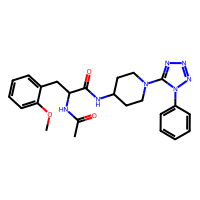
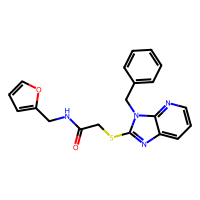
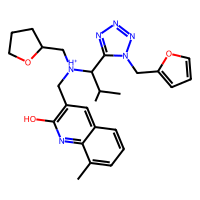
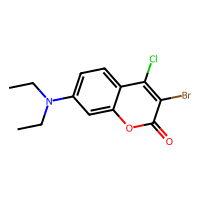
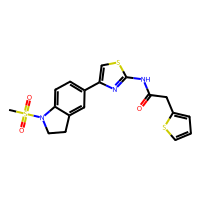
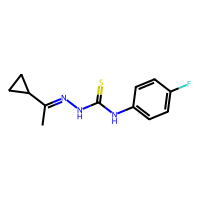
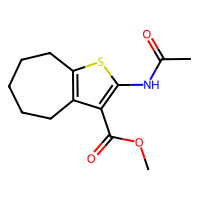
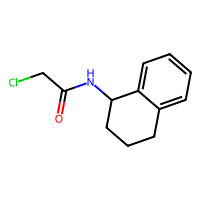
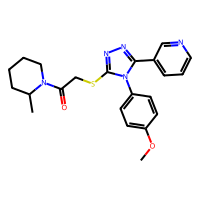
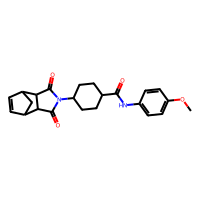

In [3]:
df_tested_molecules1 = pd.read_csv('tested_molecules-1.csv')
df_tested_molecules2 = pd.read_csv('tested_molecules_v2.csv')
df = pd.concat([df_tested_molecules1, df_tested_molecules2], ignore_index=True)
df_molecules = df.copy(deep=True)
smiles_good_inhibitor = df[df['ALDH1_inhibition'] == 1].reset_index()
smiles_bad_inhibitor = df[df['ALDH1_inhibition'] == 0].reset_index()

PandasTools.AddMoleculeColumnToFrame(df_molecules, smilesCol='SMILES')
df_molecules['original_index'] = df_molecules.index
df_molecules

In [4]:
def plot_mol (smiles_df, molecule_index):
    smiles = smiles_df['SMILES'][molecule_index]
    mol =Chem.MolFromSmiles(smiles)
    Draw.MolToMPL(mol, size=(200, 200))


In [5]:
def plot_list_mol(smiles_df):
    mol_list = []
    for smiles in smiles_df:
        for smiles in smiles_df['SMILES']:    # assuming your column is called Smiles
            mol = Chem.MolFromSmiles(smiles)
            Chem.SanitizeMol(mol,sanitizeOps=Chem.SANITIZE_SYMMRINGS|Chem.SANITIZE_SETCONJUGATION|Chem.SANITIZE_SETHYBRIDIZATION)
            mol.Compute2DCoords()
            mol_list.append(mol)
            Draw.MolToMPL(mol, size=(200, 200))

In [6]:
def rdkit_numpy_convert(fp):
    output = []
    for f in fp:
        arr = np.zeros((1,))
        DataStructs.ConvertToNumpyArray(f, arr)
        output.append(arr)
    return np.asarray(output)

In [7]:
#split fingerprint data set in training and test set
seed = 42
X_train, X_test, y_train, y_test = train_test_split(df_molecules, df_molecules['ALDH1_inhibition'], stratify=df_molecules['ALDH1_inhibition'],test_size=0.25, random_state=seed)

X_train = X_train.reset_index()
X_test = X_test.reset_index()
y_train = y_train.reset_index()
y_test = y_test.reset_index()

In [8]:
X_train_fp = rdkit_numpy_convert([AllChem.GetMorganFingerprintAsBitVect(x,3) for x in X_train['ROMol']])
X_test_fp = rdkit_numpy_convert([AllChem.GetMorganFingerprintAsBitVect(x,3) for x in X_test['ROMol']])
y_train_fp = y_train['ALDH1_inhibition'].copy()
y_test_fp = y_test['ALDH1_inhibition'].copy()

In [92]:
#X_train_fp.corrwith(y_train_fp, axis=1)

AttributeError: 'numpy.ndarray' object has no attribute 'corrwith'

In [59]:
#create 10 folds
cv = StratifiedKFold(n_splits=10)

In [60]:
# create grid search dictionary
#param_grid = {"max_features": [X_train_fp.shape[1] // 10, X_train_fp.shape[1] // 7, X_train_fp.shape[1] // 5, X_train_fp.shape[1] // 3], 
 #             "n_estimators": [100, 250, 500]}

param_grid = {"n_estimators": [1500]}
model = RandomForestClassifier(random_state =42,
                              n_estimators = 1500, min_samples_split = 5, min_samples_leaf=4,
                              max_features = 'sqrt', max_depth=80, bootstrap= False)


In [61]:
m = GridSearchCV(model, param_grid,cv=cv, n_jobs=2, verbose=1)


In [88]:
m.fit(X_train_fp, y_train_fp)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(bootstrap=False, max_depth=80,
                                              min_samples_leaf=4,
                                              min_samples_split=5,
                                              n_estimators=1500,
                                              random_state=42),
             n_jobs=2, param_grid={'n_estimators': [1500]}, verbose=1)

In [89]:
filename = 'Randomforest_morgan.sav'
pickle.dump(m, open(filename, 'wb'))

In [90]:
m.cv_results_['mean_test_score'][0], m.cv_results_['std_test_score'][0]

(0.8066666666666666, 0.02633122354417533)

In [91]:
pred_morgan = m.predict(X_test_fp)
accuracy_score(y_test_fp, pred_morgan), matthews_corrcoef(y_test_fp, pred_morgan), cohen_kappa_score(y_test_fp, pred_morgan)

(0.812, 0.5284549702614975, 0.5194274028629857)

In [116]:
pred_prob_morgan = m_mordred.predict_proba(X_test_mor)
df_pred_prob_morgan = pd.DataFrame(data=pred_prob_morgan, columns=['not inhibitor', 'inhibitor'])
df_pred_prob_morgan['molecule_index'] = df_pred_prob_morgan.index
df_pred_prob_morgan = df_pred_prob_morgan.sort_values(by='inhibitor', ascending=False)

top100_predicted = X_test.iloc[df_pred_prob_morgan['molecule_index'].iloc[0:100]].copy()
top100_labels = y_test.iloc[df_pred_prob_morgan['molecule_index'].iloc[0:100]].copy()
PandasTools.AddMoleculeColumnToFrame(top100_predicted, smilesCol='SMILES')
top100_predicted
top100_labels[top100_labels['ALDH1_inhibition']==1]['ALDH1_inhibition'].shape

(78,)

## Mordred descriptors model

In [86]:
#Split data into Test data set and training data set before doing anything.
mordred_calc = Calculator(descriptors, ignore_3D=True)

X_train_mor =  mordred_calc.pandas(mol for mol in X_train['ROMol'])
X_train_mor = X_train_mor.select_dtypes(include=['float64', 'int64', 'float'])

X_test_mor = mordred_calc.pandas(mol for mol in X_test['ROMol'])
X_test_mor = X_test_mor[X_train_mor.columns]

y_train_mor = y_train['ALDH1_inhibition'].copy()
y_test_mor = y_test['ALDH1_inhibition'].copy()

1500it [01:16, 19.54it/s]
500it [00:28, 17.53it/s]


In [87]:
X_train_mor.shape

(1500, 1124)

In [88]:
X_corr = X_train_mor.corrwith(y_train_mor, axis=0).sort_values(ascending=False)

corr_features =X_corr.drop(index=X_corr[X_corr.isna()].index).index


In [89]:
X_train_mor=X_train_mor[corr_features]
X_test_mor = X_test_mor[corr_features]


In [90]:
# Create correlation matrix
corr_matrix = X_train_mor.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

# Drop features 
X_train_mor.drop(to_drop, axis=1, inplace=True)
X_test_mor.drop(to_drop, axis=1, inplace=True)
X_train_mor.shape

(1500, 489)

In [91]:
 #X_train_mor = np.concatenate((X_train_fp, X_train_mor), axis=1)
#X_test_mor = np.concatenate((X_test_fp, X_test_mor), axis=1)

In [92]:
#create 10 folds
cv = StratifiedKFold(n_splits=10)

In [93]:
# create grid search dictionary
param_grid = {"gamma": [1]}
model = XGBClassifier(random_state =123, n_jobs=2,
                subsample = 0.6, n_estimators = 1500, min_child_weight=5,
                max_depth = 10, learning_rate=0.01, gamma= 1,
                colsample_bytree = 0.9)

In [94]:
m_mordred = GridSearchCV(model, param_grid,cv=cv, n_jobs=2, verbose=1)

In [95]:
# run model building
m_mordred.fit(X_train_mor, y_train_mor)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.9,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=1, gpu_id=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.01, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=10,
                                     max_leaves=None, min_child_weight=5,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=1500, n_jobs=2,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=123, ...),
             n_jobs=2, param_grid={'gamma': [1]}, verbose=1)

In [96]:
#filename = 'SVC_mordred_featureselected_morganfingerprint.sav'
#pickle.dump(m_mordred, open(filename, 'wb'))

In [97]:
m_mordred.cv_results_['mean_test_score'][0], m_mordred.cv_results_['std_test_score'][0]

(0.804, 0.03129785225148133)

In [98]:
#m_mordred = pickle.load(open("Randomforest_mordred_morgan.sav", 'rb'))

In [99]:
#let model predict
pred_mordred = m_mordred.predict(X_test_mor)

In [100]:
accuracy_score(y_test_mor, pred_mordred), matthews_corrcoef(y_test_mor, pred_mordred), cohen_kappa_score(y_test_mor, pred_mordred)

(0.814, 0.5530444261808679, 0.5528846153846154)

In [101]:
roc_auc_score(y_test_mor, pred_mordred)

0.7738095238095238

In [102]:
tn, fp, fn, tp = confusion_matrix(y_test_mor, pred_mordred).ravel()
print(tn, fp, fn, tp)

306 44 49 101


,index,SMILES,ALDH1_inhibition,ROMol,original_index
38,1862,CCOC(=O)c1sc(NC(=O)C2C3C=CC(C3)C2C(=O)[O-])nc1C,1,,1862
407,1744,Cc1cccc(NC(=O)c2cc(NC(=O)C3CCCCC3C(=O)[O-])ccc...,1,,1744
160,1779,CC(=O)c1nc(N2C(=O)C3CC=C(C)CC3C2=O)sc1C,1,,1779
265,1821,CCOC(=O)c1c(/N=C/[C-]2C(=O)CC(C)(C)CC2=O)sc(C)c1C,1,,1821
69,1717,CC1=C(C)CC(C(=O)N2CC[NH+](Cc3ccccc3)CC2)C(C(=O...,1,,1717
...,...,...,...,...,...
383,236,O=C(c1ccc(N2CCCCCC2)c([N+](=O)[O-])c1)N1CCC2(C...,1,,236
493,1762,Cc1ccc(S(=O)(=O)CC(=O)c2cc(C)c(O)c(C)c2)cc1,1,,1762
319,271,COc1ccc(C(CNC(=O)c2ccc(S(=O)(=O)N(C)C)cc2)[NH+...,1,,271
133,304,C[C@@H]1CCCC(CC(=O)[O-])(CC(=O)[O-])C1,0,,304

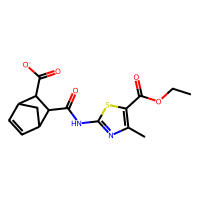
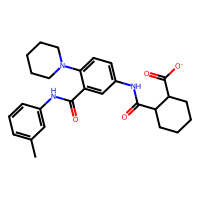
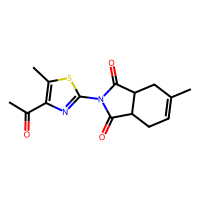
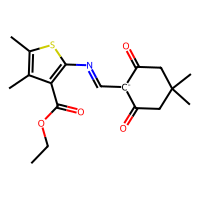
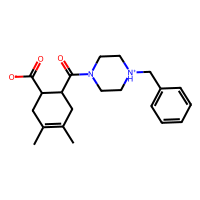
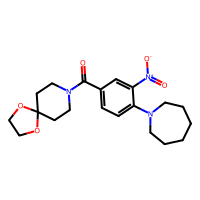
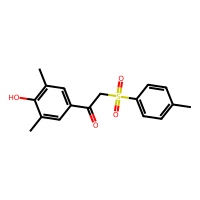
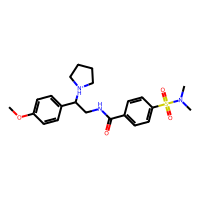
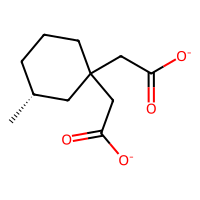
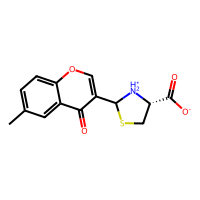

In [103]:
pred_prob_mordred = m_mordred.predict_proba(X_test_mor)

df_pred_prob_mordred = pd.DataFrame(data=pred_prob_mordred, columns=['not inhibitor', 'inhibitor'])
df_pred_prob_mordred['molecule_index'] = df_pred_prob_mordred.index
df_pred_prob_mordred = df_pred_prob_mordred.sort_values(by='inhibitor', ascending=False)

top100_predicted = X_test.iloc[df_pred_prob_mordred['molecule_index'].iloc[0:100]].copy()
top100_labels = y_test.iloc[df_pred_prob_mordred['molecule_index'].iloc[0:100]].copy()
PandasTools.AddMoleculeColumnToFrame(top100_predicted, smilesCol='SMILES')
top100_predicted

In [104]:
top100_labels[top100_labels['ALDH1_inhibition']==1]['ALDH1_inhibition'].shape

(73,)

# Untested molecules prediction

In [108]:
df_untested_moldecules = pd.read_csv('untested_molecules.csv')
PandasTools.AddMoleculeColumnToFrame(df_untested_moldecules, smilesCol='SMILES')
df_untested_moldecules_descriptors = mordred_calc.pandas(mol for mol in df_untested_moldecules['ROMol'])

10000it [10:50, 15.37it/s]


In [112]:
df_untested_features = df_untested_moldecules_descriptors[X_train_mor.columns]

,SMILES,ROMol
7636,CC(=O)c1cccc(/N=C/C2=C([O-])OC3(CCCCC3)OC2=O)c1,
4530,CCOC(=O)c1c(N2C(=O)CC(Sc3ccccc3C(=O)[O-])C2=O)...,
200,CCN(CC)c1ccc(/C=C2\C(=O)c3ccc(C(=O)[O-])cc3C2=...,
9762,N#Cc1c(NC(=O)C2CC(Cl)=CCC2C(=O)[O-])sc2c1CCCC2,
5151,O=C([O-])C1C2C=CC(O2)C1C(=O)NCc1ccccc1Br,
...,...,...
8715,O=C(C1CCC(CNS(=O)(=O)c2cccc3cccnc23)CC1)N1CCc2...,
5245,CCN(CC)C(=O)c1sc(N2C(=O)Nc3ccccc3N2[O-])c(C(=O...,
3082,CSc1ccccc1/N=C/C1=C([O-])CC(C)(C)CC1=O,
3232,Cc1ccsc1/C=C1\SC(=S)N(CC2CCCO2)C1=O,

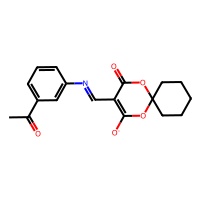
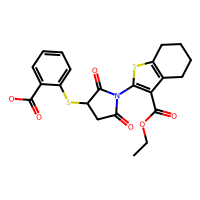
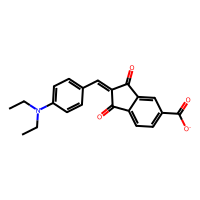
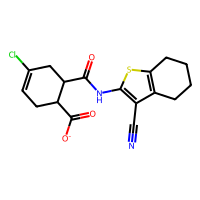
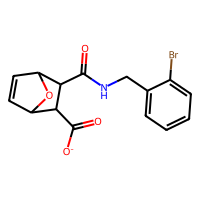
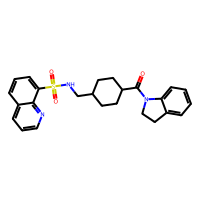
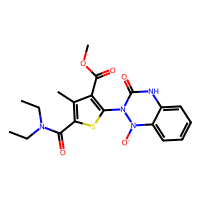
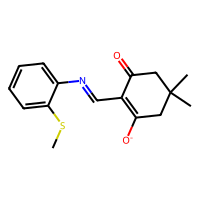
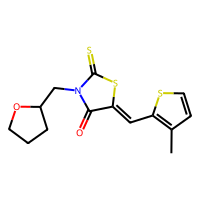
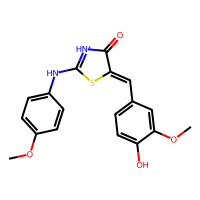

In [119]:
pred_prob_mordred = m_mordred.predict_proba(df_untested_features)

df_pred_prob_mordred = pd.DataFrame(data=pred_prob_mordred, columns=['not inhibitor', 'inhibitor'])
df_pred_prob_mordred['molecule_index'] = df_pred_prob_mordred.index
df_pred_prob_mordred = df_pred_prob_mordred.sort_values(by='inhibitor', ascending=False)

top100_predicted = df_untested_moldecules.iloc[df_pred_prob_mordred['molecule_index'].iloc[0:100]].copy()
PandasTools.AddMoleculeColumnToFrame(top100_predicted, smilesCol='SMILES')
top100_predicted['SMILES'].to_csv('Group11_top100_predictions.csv')
top100_predicted